# Train HeterSUMGraphe

In [1]:
import pandas as pd
import argparse
from time import time
import torch
import numpy as np
import random
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader
from sklearn.utils import shuffle
import json
import os
import networkx as nx
import torch_geometric
from statistics import mean
import matplotlib.pyplot as plt

from tqdm import tqdm

from utils.create_graph_dataset import create_graph_dataset
from utils.GloveMgr import GloveMgr

In [2]:
def is_notebook() -> bool:
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return True   # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        return False      # Probably standard Python interpreter

## (Hyper-)parameters

In [3]:
# Parse args if script mode
parser = argparse.ArgumentParser(description='extractive summary')

parser.add_argument('-is_graphic',type=int,default=1,choices=[0,1])
parser.add_argument('-gpu_num',type=int,default=0)
parser.add_argument('-batch_size',type=int,default=1)
parser.add_argument('-epochs',type=int,default=100)
parser.add_argument('-dataset',type=str,default="data/nyt_corpus_LDC2008T19_50.json")

args = None

if is_notebook():
    args = parser.parse_args("")
else:
    args = parser.parse_args()

In [4]:
# parameters
is_graphic = args.is_graphic != 0
cuda_num = args.gpu_num
embed_name = "glove.6B.300"

# hyper-parameters
vocab_size = 50000
batch_size = args.batch_size
epochs = args.epochs
learning_rate = 5e-4
early_stopping = 3
word_blacklist_proportion = 0.1
model_name = "HeterSUMGraph"
sub_folder_name = "model_name__{}__time__{}__embed_name__{}__lr__{}__batch_size__{}__vocab_size__{}__cuda_num__{}__early_stopping__{}".format(model_name, time(), embed_name, learning_rate, batch_size, vocab_size, cuda_num, early_stopping)
checkpoints_folder = "./checkpoints/" + sub_folder_name
average_proportion_of_sentences_per_document = 0.2670278281534701
average_number_of_sentences_per_document = 6.061850780738518

# print
print("parse:")
print("is_graphic:", is_graphic)
print("cuda_num:", cuda_num)
print("epochs", epochs)
print("batch_size", batch_size)

parse:
is_graphic: True
cuda_num: 0
epochs 100
batch_size 1


## PyTorch initialisation

In [5]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [6]:
# Check if a GPU is available
if torch.cuda.is_available():
    # Display the number of available GPUs
    print(f"Number of available GPUs: {torch.cuda.device_count()}")
    # Display the name of each GPU
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No GPU available.")

Number of available GPUs: 1
GPU 0: NVIDIA GeForce RTX 3060


In [7]:
if torch.cuda.is_available():  
  dev = "cuda:" + str(cuda_num) 
else:  
  dev = "cpu" 

device = torch.device(dev)
device

device(type='cuda', index=0)

## load data

In [8]:
df = pd.read_json(args.dataset)
df = shuffle(df)

df_test = df.iloc[0:3452]
df_val = df.iloc[3452:7452]
df_train = df.iloc[7452:8000]

In [9]:
glovemgr = GloveMgr("./data/glove.6B/glove.6B.300d.txt", vocab_size=vocab_size)

In [10]:
tfidfs_sent = pd.read_json("data/nyt50_sent_tfidf.json")
tfidfs_sent = tfidfs_sent["tfidf"].to_numpy()

In [11]:
tfidfs_dataset = json.load(open("./data/nyt50_dataset_tfidf.json"))
tfidfs_dataset_sorted = sorted(tfidfs_dataset, key=tfidfs_dataset.get)
word_blacklist = set(tfidfs_dataset_sorted[:int(word_blacklist_proportion*len(tfidfs_dataset_sorted))])

In [12]:
train_dataset = create_graph_dataset(df=df_train, tfidfs_sent=tfidfs_sent, glovemgr=glovemgr, word_blacklist = word_blacklist, remove_unkn_words=False, doc_column_name="docs", labels_column_name="labels", is_sep_n=False, remove_stop_word = False, stemming=False, trunc_sent=-1, padding_sent=-1, trunc_doc=50)
val_dataset = create_graph_dataset(df=df_val, tfidfs_sent=tfidfs_sent, glovemgr=glovemgr, word_blacklist = word_blacklist, remove_unkn_words=False, doc_column_name="docs", labels_column_name="labels", is_sep_n=False, remove_stop_word = False, stemming=False, trunc_sent=-1, padding_sent=-1, trunc_doc=50)
test_dataset = create_graph_dataset(df=df_test, tfidfs_sent=tfidfs_sent, glovemgr=glovemgr, word_blacklist = word_blacklist, remove_unkn_words=False, doc_column_name="docs", labels_column_name="labels", is_sep_n=False, remove_stop_word = False, stemming=False, trunc_sent=-1, padding_sent=-1, trunc_doc=50)

In [13]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader =  DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader =  DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Graph stats

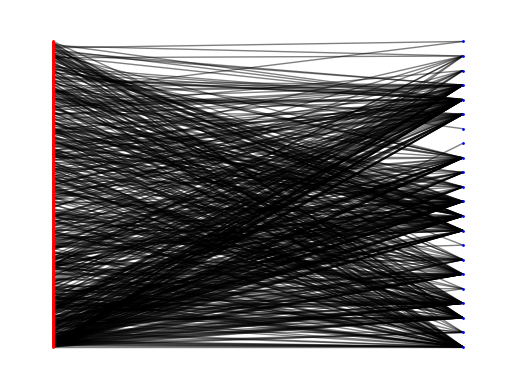

In [14]:
# draw one graph
if is_notebook():
  data = train_dataset.dataset[0]['docs']
  #g = torch_geometric.utils.to_networkx(data)
  #nx.draw(g, node_color= [0 for _ in data.x[0]] + [1 for _ in data.x[1]])
  # Convert to networkx
  G = nx.Graph()
  G.add_nodes_from(range(data.x[0].shape[0]), bipartite=0)
  G.add_nodes_from(range(data.x[1].shape[0]), bipartite=0)
  edge_list = data.edge_index.transpose(0, 1).tolist()
  G.add_edges_from(edge_list)
  # draw
  pos = nx.bipartite_layout(G, nodes=range(data.x[0].shape[0]))
  nx.draw_networkx_nodes(G, pos, nodelist=range(data.x[0].shape[0]), node_color='r', node_size=1)
  nx.draw_networkx_nodes(G, pos, nodelist=range(data.x[0].shape[0], data.x[0].shape[0] + data.x[1].shape[0]), node_color='b', node_size=1)
  nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5, edge_color='k')
  plt.axis('off')
  plt.show()
  

In [15]:
# Average number of distinct word per doc
print("Average number of distinct word per doc:", mean([len(t["docs"].x[0]) for t in train_dataset]))

Average number of distinct word per doc: 407.3211678832117


In [16]:
def sents_len(doc):
  return [sum([w != 0 for w in s]) for s in doc]

# Average sentence length
lens = []
for t in train_dataset:
  lens = lens + sents_len(t["docs"].x[1].numpy())

print("Average sentence len:", mean(lens))

Average sentence len: 34


In [17]:
# Average density
def density(g):
  nb_edges = g.num_edges / 2
  nb_nodes = g.num_nodes
  nb_poss_edges = nb_nodes * (nb_nodes - 1) / 2
  return nb_edges / nb_poss_edges

print("Average density:", mean([density(t["docs"]) for t in train_dataset]))

Average density: 0.011468567521115844


/home/rsaid/anaconda3/lib/python3.9/site-packages/torch_geometric/data/storage.py:280: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_index', 'x', 'undirected', 'edge_attr'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


In [18]:
# Average clustering
def average_clustering(g):
  G = nx.Graph()
  edge_list = g.edge_index.t().tolist()
  G.add_edges_from(edge_list)
  return nx.average_clustering(G)

print("Average clustering:", mean([average_clustering(t["docs"]) for t in train_dataset]))

Average clustering: 0.0


## Model

In [19]:
import torch.nn as nn

In [ ]:
# own GAT
class GAT(nn.Module):
  def __init__(self) -> None:
    super(GAT).__init__()
    # TODO

  def forward(self):
    None

In [32]:
class HeterSUMGraph(torch.nn.Module):
  def __init__(self, device, vocab_size, word_embed = None, dim_word_embed = 300, num_iter=3):
    super(HeterSUMGraph, self).__init__()
    self.device = device
    self.num_iter = num_iter

    self.word_emb = nn.Embedding(vocab_size+2, dim_word_embed, padding_idx=0)

    # Load word embedding if specified
    if word_embed is not None:
      self.word_embedding = torch.nn.Embedding.from_pretrained(torch.from_numpy(word_embed).float())

    self.word_emb.weight.requires_grad = False

    # sent CNN
    dim_out_cnn = 40
    self.convs = nn.Sequential(
                            nn.Conv1d(in_channels=300,out_channels=100,kernel_size=3,padding='same'),
                            nn.BatchNorm1d(num_features=100),
                            nn.ReLU(inplace=True),
                            nn.Conv1d(in_channels=100,out_channels=100,kernel_size=4,padding='same'),
                            nn.BatchNorm1d(num_features=100),
                            nn.ReLU(inplace=True),
                            nn.Conv1d(in_channels=100,out_channels=dim_out_cnn,kernel_size=5,padding='same'),
                            nn.BatchNorm1d(num_features=dim_out_cnn),
                            nn.ReLU(inplace=True))

    # sent LSTM
    dim_out_lstm = 44
    self.sent_LSTM = nn.LSTM(input_size=300, hidden_size=dim_out_lstm, batch_first=True, bidirectional=True)

    # sent to word GAT
    self.s2wGAT = GAT()

    # word to sen GAT
    self.w2sGAT = GAT()

    self.wh = nn.Linear(128, 1)

  def max_pool1d(self, x, seq_lens):
    out = []
    for index,t in enumerate(x):
      if seq_lens[index] == 0:
        t = t[:1]
      else:
        t = t[:seq_lens[index],:]
      t = torch.t(t).unsqueeze(0)
      out.append(torch.avg_pool1d(t, t.size(2)))

    out = torch.cat(out).squeeze(2)
    return out

  def forward(self, data, doc_lens):# In the real implémentation remove nb_sent
    # features
    Xw = data.x[0]
    Xs = data.x[1]
    sent_lens = torch.sum(torch.sign(Xs),dim=1).data
    
    # embeddings
    Xw = self.word_emb(Xw)
    Xs = self.word_emb(Xs)

    # CNN
    XsCNN = self.convs(Xs.permute(0,2,1))
    XsCNN = torch.max_pool1d(XsCNN, XsCNN.size(2)).squeeze(2)

    # LSTM
    # TO DO: ask 
    XsLSTM, _ = self.sent_LSTM(Xs)
    XsLSTM = self.max_pool1d(XsLSTM, sent_lens)
    Xs = torch.cat((XsCNN, XsLSTM), dim=1)

    w_state = Xw
    s_state = Xs

    for i in range(self.num_iter):
      w_state = None# TODO
      s_state = None# TODO

    res = self.wh(s_state)

    return res

In [33]:
model = HeterSUMGraph(device=device, vocab_size=vocab_size, word_embed=glovemgr.getEmbeddings(), dim_word_embed=300)#.to(device=device)

In [34]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Train

In [35]:
if not os.path.exists(checkpoints_folder):
  os.makedirs(checkpoints_folder)

In [36]:
arr_train_loss = []
arr_val_loss = []

t1 = time()

for epoch in range(1, epochs+1):
  model.train()
  nb_batch_train = 0
  total_train_loss = 0
    
with tqdm(train_loader, unit="batch", total=len(train_loader)) as tepoch:
  for batch in tepoch:
    tepoch.set_description(f"Epoch {epoch}")
    doc_lens = batch["doc_lens"]
    data = batch["docs"]#.to(device)
    targets = batch["labels"]
    print(targets)
    y_pred = model(data, doc_lens)

    while True:
      None
t2 = time()
print("Training duration =", t2-t1)

  0%|          | 0/548 [00:00<?, ?batch/s]/home/rsaid/anaconda3/lib/python3.9/site-packages/torch_geometric/data/storage.py:280: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_index', 'x', 'undirected', 'edge_attr'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(
Epoch 100:   0%|          | 0/548 [00:00<?, ?batch/s]

[tensor([1]), tensor([1]), tensor([1]), tensor([0]), tensor([1]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([1]), tensor([0]), tensor([1]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([0]), tensor([1])]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (9x128 and 300x64)